In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

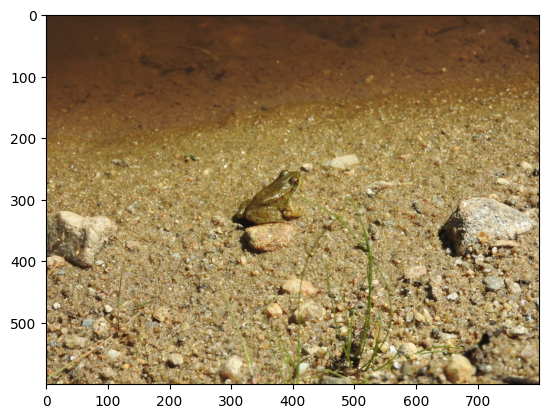

In [2]:

image_path = "nature_12K/inaturalist_12K/train/Amphibia/0a23c86d7abf365aea549f9ce58025cd.jpg"  # Replace "path_to_your_image.jpg" with the path to your image file
img = mpimg.imread(image_path)


plt.imshow(img)
plt.show()

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from sklearn.model_selection import train_test_split

2024-03-11 22:49:10.109753: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 22:49:10.250539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 22:49:12.998718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def build_cnn(num_filters, filter_size, input_shape, num_classes, dense_neurons):

    model = Sequential()

    for i in range(5):
        model.add(Conv2D(num_filters, filter_size, padding='same', input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_neurons))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [5]:
num_filters = 16
filter_size = (3, 3)
input_shape = (64, 64, 3)  # Assuming input image size is 64x64 with 3 channels
num_classes = 10
dense_neurons = 256

# Build the model
model = build_cnn(num_filters, filter_size, input_shape, num_classes, dense_neurons)
model.summary()

/home/saranath/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,938 (113.04 KB)

 Trainable params: 28,938 (113.04 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
train_data_dir = 'nature_12K/inaturalist_12K/train'
test_data_dir = 'nature_12K/inaturalist_12K/val'

In [7]:
import os
import shutil

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)

# List all files in the source directory
files = os.listdir(train_data_dir)

In [22]:
files

['Plantae',
 '.DS_Store',
 'Aves',
 'Amphibia',
 'Insecta',
 'Animalia',
 'Mollusca',
 'Fungi',
 'Arachnida',
 'Reptilia',
 'Mammalia']

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Define the root directory
root_dir = 'nature_12K'

# Get the list of class folders
class_folders = ['Plantae', 'Aves', 'Amphibia', 'Insecta', 'Animalia', 'Mollusca',
                 'Fungi', 'Arachnida', 'Reptilia', 'Mammalia']

# Initialize empty lists to store image paths and corresponding labels
X = []
y = []

# Iterate over each class folder
for i, class_folder in enumerate(class_folders):
    class_path = os.path.join(root_dir, 'inaturalist_12K', 'train', class_folder)
    # Get the list of image files in the class folder
    image_files = os.listdir(class_path)
    # Append image paths and corresponding labels to the lists
    X.extend([os.path.join(class_path, img) for img in image_files])
    y.extend([i] * len(image_files))  # Assign label i to each image

# Convert labels to numpy array
y = np.array(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)




In [9]:
X_train[0], y_train[0]

('nature_12K/inaturalist_12K/train/Reptilia/e95e0320e4f33db1ae55f633f75ec0c0.jpg',
 8)

In [11]:
def load_images(image_paths):
    images = []
    i = 0
    for img_path in image_paths:
        if i < 5:
            try:
                img = mpimg.imread(img_path)  # Resize images to a specific size if needed
                img_array = img_to_array(img)
                images.append(img_array)
            except:
                print(f"Error loading image: {img_path}. Skipping...")
        i += 1
    return images
# img = mpimg.imread(X_train[0])


# plt.imshow(img)
# plt.show()
X_train1 = load_images(X_train)
X_val1 = load_images(X_val)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.